In [44]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import utils as utils

In [45]:
train_path = '../data/train.csv'
test_path = '../data/test.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
train_data.describe()

,text,label
count,34823,34823
unique,34772,5
top,FEARLESS FRIDAYS MEGA THREAD. Here we discuss ...,self.depression
freq,13,11940


In [51]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])

# Convert text to sequences and pad them
max_length = max([len(s.split()) for s in train_data['text']])
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

X_train = pad_sequences(train_sequences, maxlen=max_length)
X_test = pad_sequences(test_sequences, maxlen=max_length)

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])
y_test = label_encoder.transform(test_data['label'])

In [52]:
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
output_units = len(label_encoder.classes_)  # Number of classes

#converting encoded labels to one_hot encoding
y_train_one_hot = to_categorical(y_train, output_units)
y_test_one_hot = to_categorical(y_test, output_units)

In [53]:
def build_model():
    model = Sequential([
        Embedding(vocab_size, 128),
        LSTM(64, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0),
        Dense(output_units, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [54]:
results = {'precision': [], 'recall': [], 'f1': [], 'accuracy': []}

#loop through each percentage
for fraction in np.arange(0.1, 1.1, 0.1):
    model = build_model()  # Recreate the model for each iteration
    partial_X_train, _, partial_y_train, _ = train_test_split(X_train, y_train_one_hot,train_size=fraction, random_state=42)
    model.fit(partial_X_train, partial_y_train, epochs=2, batch_size=32, verbose=1)

    # Predict on X_test
    y_pred_prob = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_prob, axis=1)
    y_test_integers = np.argmax(y_test_one_hot, axis=1)

    # Calculate metrics
    precision = precision_score(y_test, y_pred_classes, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred_classes, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred_classes, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_test_integers, y_pred_classes)

    # Store metrics
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1'].append(f1)
    results['accuracy'].append(accuracy)

Epoch 1/2
 20/109 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - accuracy: 0.3195 - loss: 1.5926

KeyboardInterrupt: 

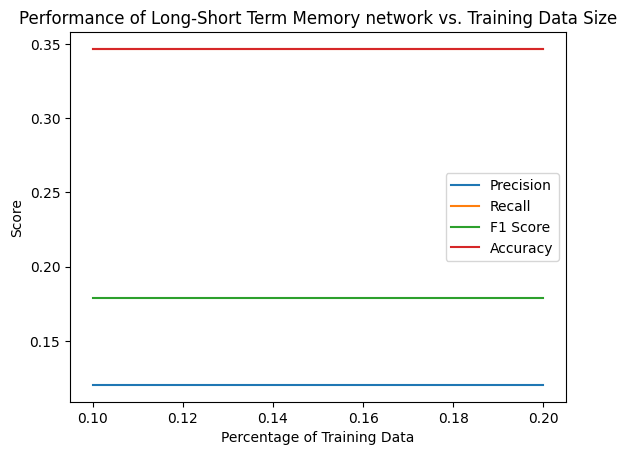

In [11]:
utils.create_graph([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], results, 'Long-Short Term Memory network', 'LSTM.png')